# TAA Project 1

In [52]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm import tqdm

### Process the data files

In [53]:
meta = pd.read_csv('dataset/Meta.csv')

test = pd.read_csv('dataset/Test.csv')

train = pd.read_csv('dataset/Train.csv')

### Distribution of images per signal on the Train set

Number of classes: 43


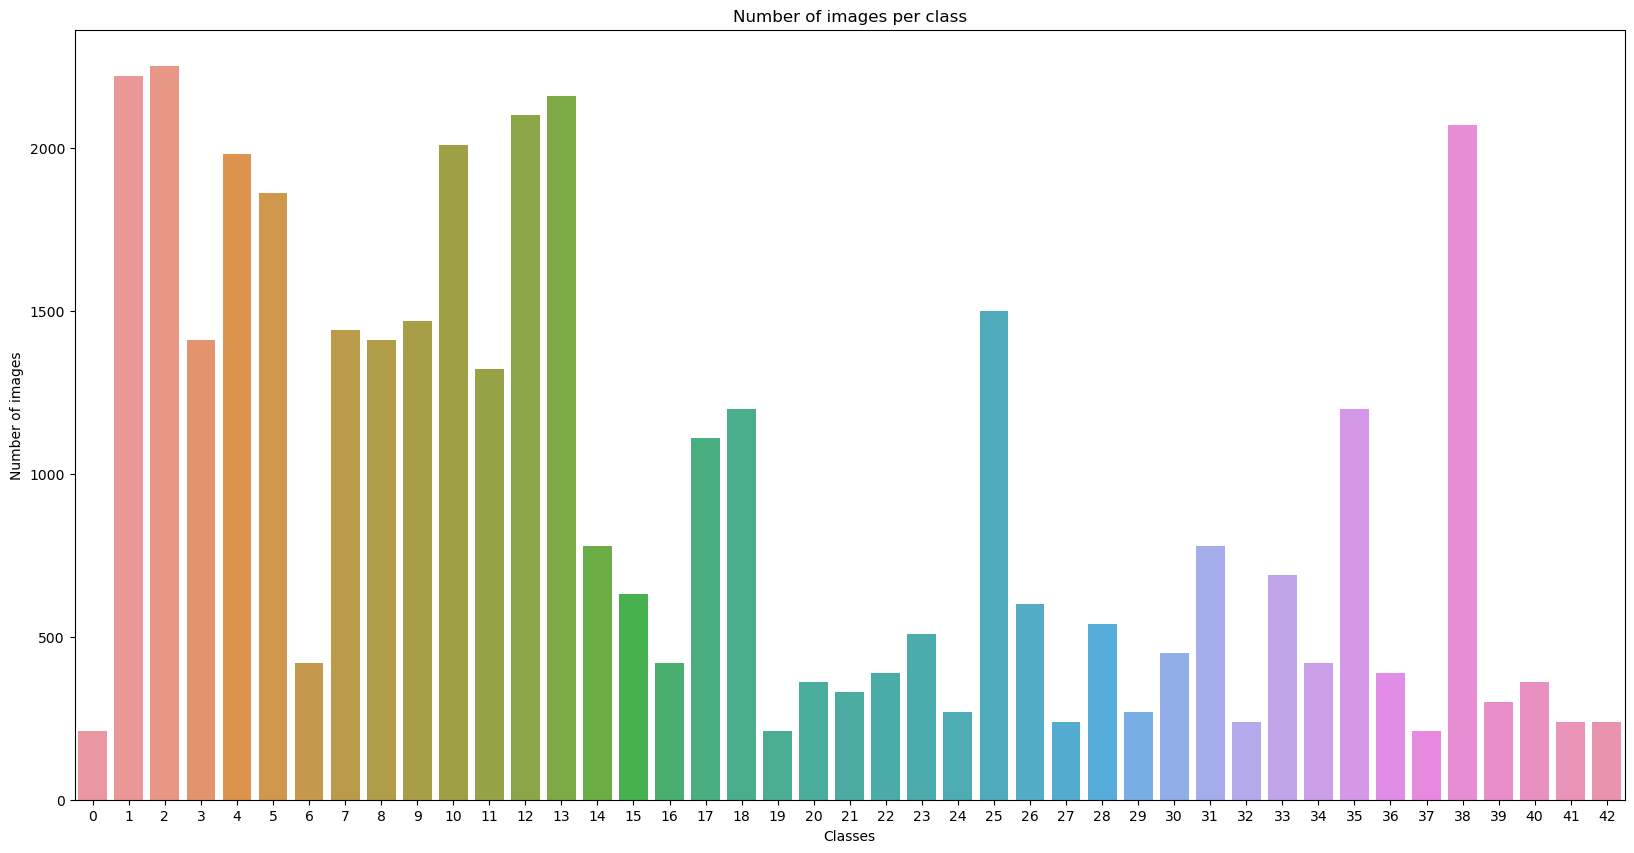

In [54]:
# Get the names of the classes
classes = meta['ClassId']
classes = np.array(classes)
classes = np.sort(classes)

print('Number of classes: {}'.format(len(classes)))

# Get the number of images per class
num_images = []
for c in classes:
    num_images.append(len(train[train['ClassId'] == c]))

# Plot the histogram
plt.figure(figsize=(20, 10))
sns.barplot(x=classes, y=num_images)
plt.title('Number of images per class')
plt.xlabel('Classes')
plt.ylabel('Number of images')
plt.savefig('train_distribution.png')
plt.show()


### Subset of images from the Train set

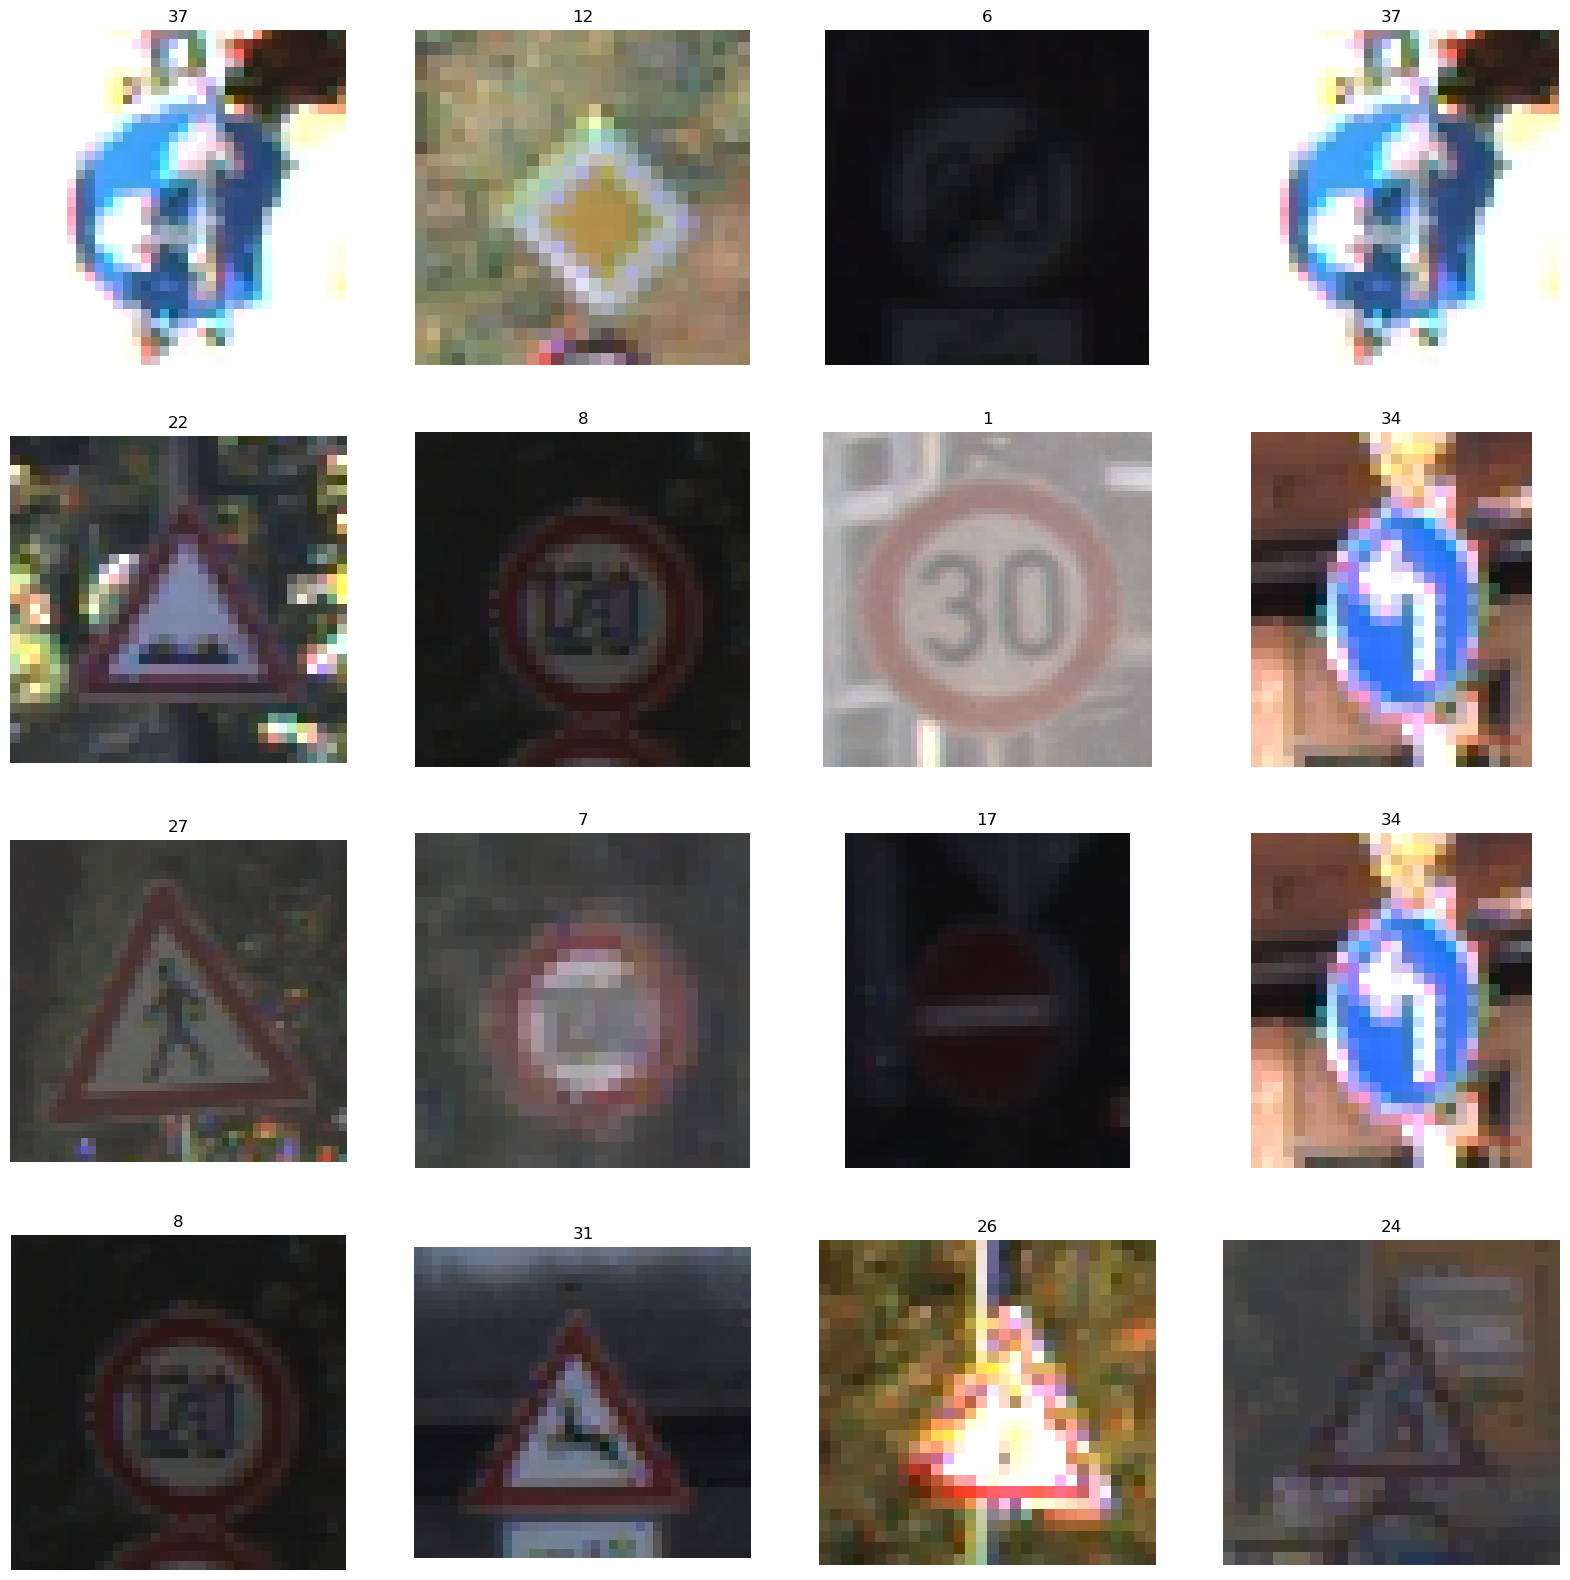

In [55]:
# get a 4x4 grid of 16 random images from the training set
TRAIN_PATH = 'dataset/Train/'
grid_size = 4
con = np.random.choice(classes, size=grid_size*grid_size)
fig, ax = plt.subplots(grid_size, grid_size, figsize=(20, 20))
for i, row in enumerate(ax):
	for j, col in enumerate(row):
		image = Image.open(TRAIN_PATH + str(con[i*grid_size + j]) + '/' + os.listdir(TRAIN_PATH + str(con[i*grid_size + j]))[0])
		col.imshow(image)
		col.axis('off')
		col.set_title(con[i*grid_size + j])
plt.savefig('train_sample.png')
plt.show()


### Subset of images from the Test set

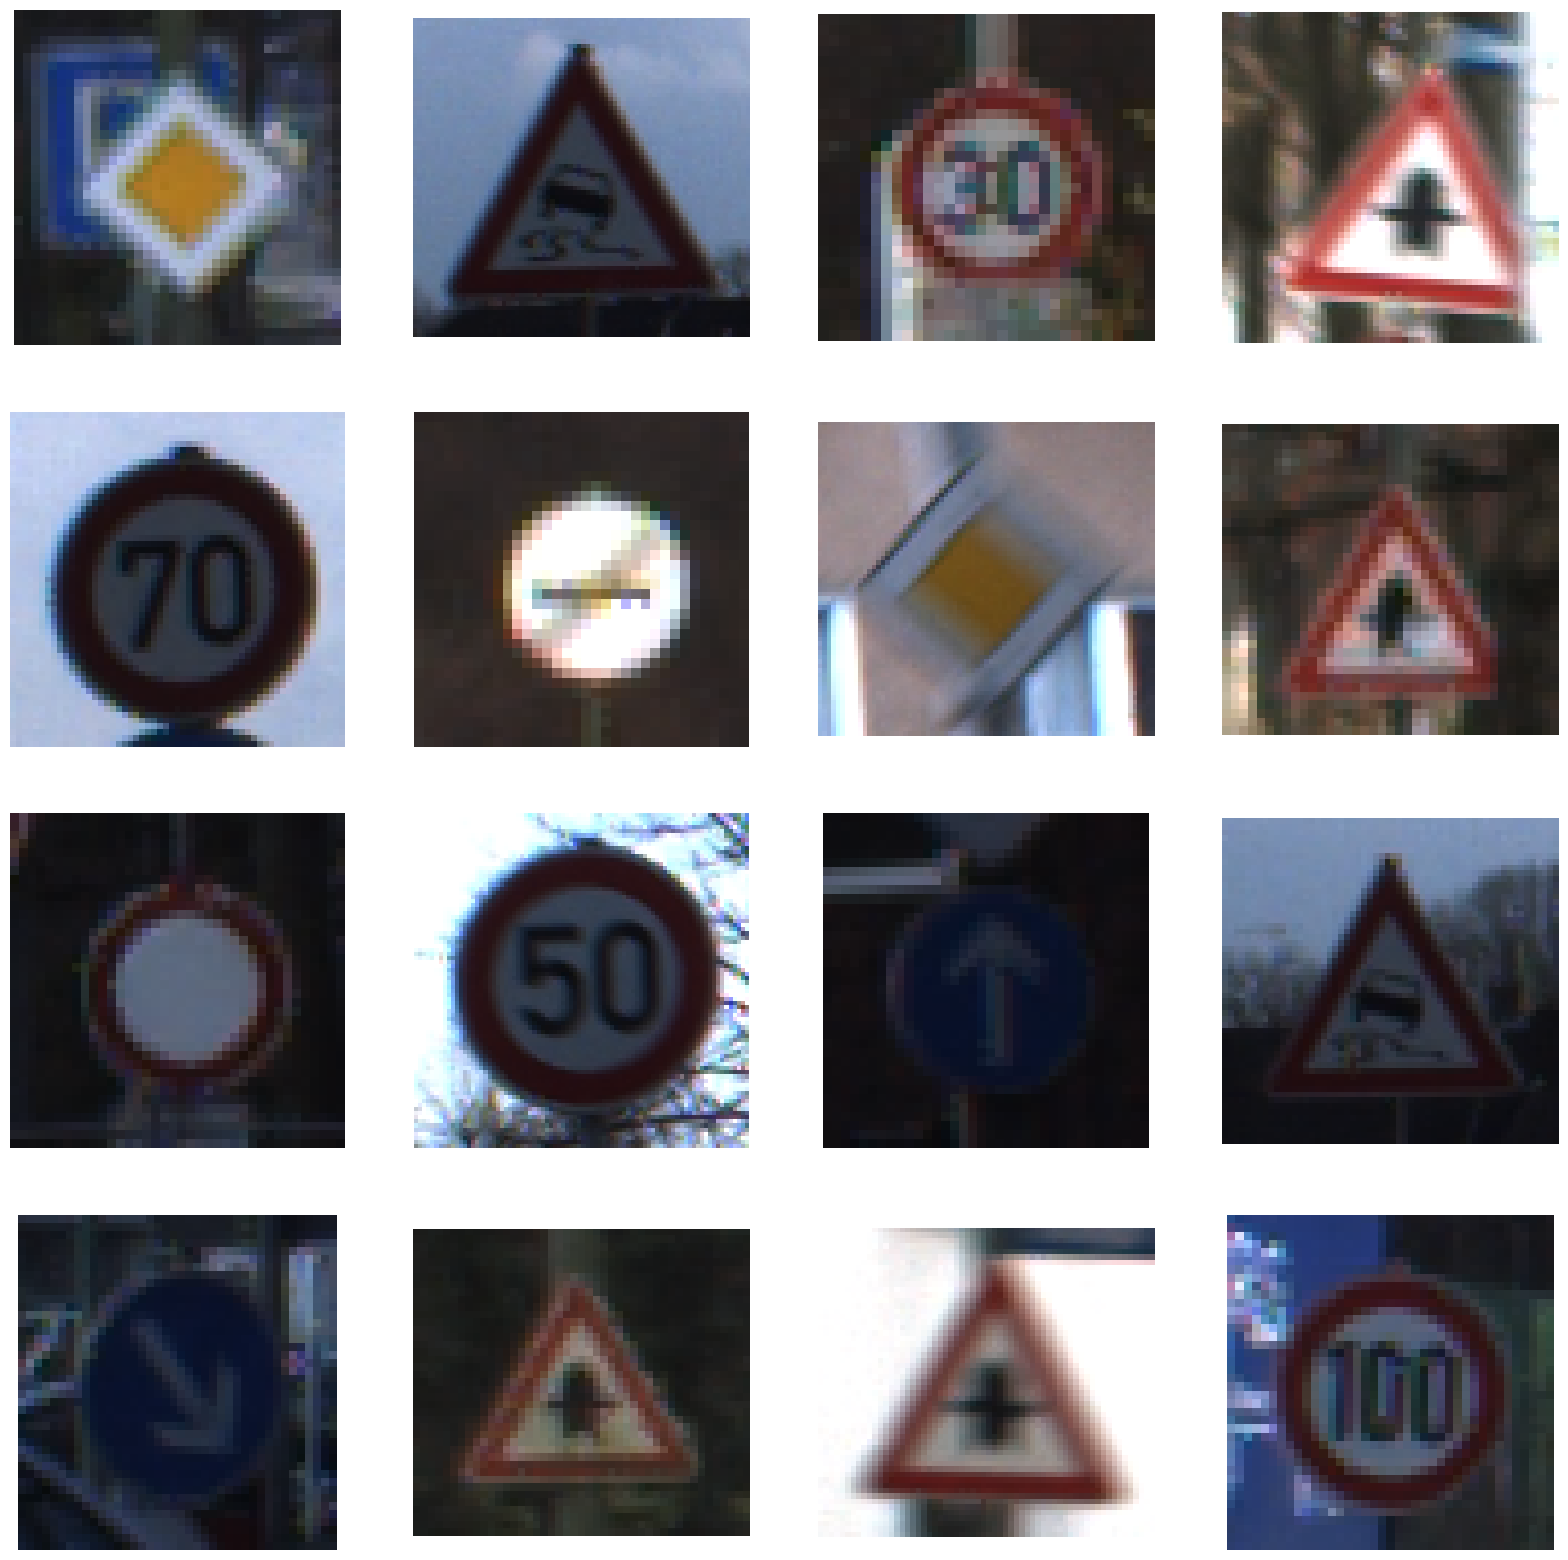

In [56]:
# get a 4x4 grid of 16 random images from the testing set
TEST_PATH = 'dataset/Test/'
grid_size = 4
fig, ax = plt.subplots(grid_size, grid_size, figsize=(20, 20))
for i, row in enumerate(ax):
	for j, col in enumerate(row):
		image = Image.open(TEST_PATH + np.random.choice(os.listdir(TEST_PATH)))
		col.imshow(image)
		col.axis('off')
plt.savefig('test_sample.png')
plt.show()
